In [50]:
import urllib.request
import pickle, csv, json, os, re
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from statistics import mode, mean, median
from tqdm import tqdm
import requests

plt.rcParams["figure.figsize"] = (20,10)

# Data

We load in our stored local animes and mangas

In [51]:
import os
anime_dir_path = "data/animes/"

anime_dir = os.listdir(anime_dir_path)
all_animes = []
for file in anime_dir:
    with open(os.path.join(anime_dir_path, file),'r') as f:
        j = json.loads(f.read())
    all_animes.append(j)

In [52]:
all_anime_tv = [x for x in all_animes if x['type'] == 'TV']
print(len(all_anime_tv))
all_anime_tv = [x for x in all_anime_tv if x['score']]
print(len(all_anime_tv))
all_anime_tv = [x for x in all_anime_tv if x['synopsis']]
print(len(all_anime_tv))

8228
4323
4304


In [53]:
all_anime_tv_id = [anime['mal_id'] for anime in all_anime_tv]
anime_graph = nx.Graph()
anime_graph.add_nodes_from(all_anime_tv_id)

fh = open("data/edgeanimelist.txt", 'r') 
anime_edge_graph = nx.read_weighted_edgelist(fh, nodetype = int)

anime_graph.add_edges_from(anime_edge_graph.edges(data = True))
print(len(anime_graph))
# anime_graph = nx.read_weighted_edgelist("data/edgeanimelist.txt")

4304


In [54]:
components = sorted(nx.connected_components(anime_graph), key=len, reverse=True)
anime_GCC = components[0]
anime_GCC = anime_graph.subgraph(anime_GCC).copy()
print(anime_GCC)

Graph with 3448 nodes and 33971 edges


In [55]:
def get_degree_properties(graph):
    out_degrees = []
    prop = {}
    prop['out'] = {}
    prop['in'] = {}
    
    for _ , d in graph.degree():
        out_degrees.append(d)
        
    prop['outdegrees'] = out_degrees

    
    prop['out']['max'] = max(out_degrees)

    
    prop['out']['min'] = min(out_degrees)

    
    prop['out']['avg'] = mean(out_degrees)

    
    prop['out']['median'] = median(out_degrees)

    
    prop['out']['mode'] = mode(out_degrees)

    
    return prop

properties = get_degree_properties(anime_GCC)
print("Out:",properties['out'])
print("In:",properties['in'])

Out: {'max': 241, 'min': 1, 'avg': 19.704756380510442, 'median': 10.0, 'mode': 1}
In: {}


In [56]:

# Overall
sorted_popular_anime = sorted(anime_GCC.degree, key=lambda x: x[1], reverse=True)[0:5]
sorted_popular_anime = [(int(x),y) for (x,y) in sorted_popular_anime]

sorted_popular_anime = [(anime['titles'][0]['title'], count) for (id, count) in sorted_popular_anime for anime in all_anime_tv if id == anime['mal_id']]
print(sorted_popular_anime)

[('Mahou Shoujo Madoka★Magica', 241), ('Code Geass: Hangyaku no Lelouch', 231), ('Neon Genesis Evangelion', 226), ('Gintama', 202), ('Tengen Toppa Gurren Lagann', 194)]


In [57]:
C_anime_full = [(k, v) for k, v in nx.degree_centrality(anime_GCC).items()]

C_anime_v = [v for k, v in nx.degree_centrality(anime_GCC).items()]
print("avg anime degree centrality:",mean(C_anime_v))

avg anime degree centrality: 0.005716494453295747


In [58]:
import random
def shuffle_network(graph):
    # create a random mapping old label -> new label
    node_mapping = dict(zip(graph.nodes(), sorted(graph.nodes(), key=lambda k: random.random())))
    # build a new graph
    R = nx.relabel_nodes(graph, node_mapping)
    
    return R

In [59]:
R = shuffle_network(anime_GCC)

print(R)

Graph with 3448 nodes and 33971 edges


In [60]:
R_anime_C = []

for i in range(1000):
    R = shuffle_network(anime_GCC)
    #Rs.append(R)
    C_anime_v = [v for k, v in nx.degree_centrality(R).items()]
    R_anime_C.append(mean(C_anime_v))

# Community Detection

In [61]:
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet as wn
from collections import defaultdict
from nltk.stem import WordNetLemmatizer
import re
import nltk
import matplotlib.pyplot as plt

In [62]:
# Lemmatization of lists
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

def lemmatizeList(list):
    lemma_list = []
    for word, tag in pos_tag(list):
        lemma = WordNetLemmatizer().lemmatize(word, tag_map[tag[0]])
        lemma_list.append(lemma)
    return lemma_list

In [63]:
def text_processing(partition, community_list):

    corpus = []
    for i in community_list:
        anime_community_ids = [key for key, value in partition.items() if value == i]
        text = ""
        # Loop through all the anime and find the one that are within the community, add text
        for anime in all_anime_tv:        
            if (anime['mal_id'] in anime_community_ids):
                end = -1
                try:
                    end = re.search("(\[Written by.*]|\(Source:.*\))",anime['synopsis']).span()[0] 
                except AttributeError:
                    pass
                
                text += anime['synopsis'][:end]
                
                # Only for anime id 5725 makes the change of word from cards to card, which does not influence
                # The end result, therefore end will be -1, in case the synopsis doesn't state the source
                if(anime['synopsis'][end].isalpha()): 
                    print(anime['mal_id'])
                
        tokens = word_tokenize(re.sub("[^0-9a-zA-Z\s]+","",text))

        # Process each document of the text of a community through lemmatization, remove stop words and only take words/numbers.
        stop_words = stopwords.words('english')

        processed_text_1 = lemmatizeList([w.lower() for w in tokens])
        processed_text_2 = [w for w in processed_text_1 if not w in stop_words]
        corpus.append(processed_text_2)

    return corpus

#### To ensure we find the same communities each time, random seed will be used

In [64]:
import random
import sys

# create a seed
seed_value = random.randrange(sys.maxsize)
# save this seed somewhere. So if you like the result you can use this seed to reproduce it
print('Seed value:', seed_value)
# Output 5329025261059076053

# Now, Seed the random number generator
random.seed(2870151239873871873)

Seed value: 7946790580321577355


In [65]:
import networkx.algorithms.community as nx_com
import community

# Since we have a lot of nodes without recommendations, it is best to find the GCC of our graph
GCC = max(nx.connected_components(anime_graph), key=len)
anime_GCC = anime_graph.subgraph(GCC).copy()

#Find the best partition for each universe - using the louvain algorithm
anime_partition = community.best_partition(anime_GCC, weight = 'weight')

In [66]:
len(anime_GCC)

3448

In [67]:
anime_partition_values = [anime_partition.get(node) for node in anime_GCC.nodes()]

In [68]:
anime_communities = {}
anime_communities2 = {}

for key in anime_partition_values:
    if key in anime_communities:
        anime_communities[key] += 1
    else:
        anime_communities[key] = 1

print("The anime network partition consists of", len(anime_communities), "communities and the sizes of the communities are", list(anime_communities.values()))

The anime network partition consists of 13 communities and the sizes of the communities are [214, 419, 416, 237, 156, 231, 275, 259, 701, 177, 204, 113, 46]


In [69]:
community.modularity(anime_partition,anime_GCC, weight = 'weight')

0.5255925955639841

#### Visualize the communities by coloring the graph's nodes according to community affiliation

In [70]:
import matplotlib.colors as colors
import fa2

def fa_community_plot(graph, partition):  
    forceatlas2 = fa2.ForceAtlas2(
                            # Behavior alternatives
                            outboundAttractionDistribution=False,
                            linLogMode=False,
                            adjustSizes=False,
                            edgeWeightInfluence=0.5,

                            # Performance
                            jitterTolerance=1.0,  # Tolerance
                            barnesHutOptimize=True,
                            barnesHutTheta=1.2,
                            multiThreaded=False,  # NOT IMPLEMENTED

                            # Tuning
                            scalingRatio=1.0,
                            strongGravityMode=True,
                            gravity=1.0,

                            # Log
                            verbose=False)

    positions = forceatlas2.forceatlas2_networkx_layout(graph, pos=None, iterations=1000)
    nx.draw_networkx_edges(graph, positions, edge_color="yellow", alpha=0.2)
    #Count is used to give each community their own color
    count = 0
    #Go through each community and draw all the nodes in the same color
    for com in set(partition.values()) :
        count = count + 1
        list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
        color = list(colors.cnames.keys())[count]
        nx.draw_networkx_nodes(graph, positions, list_nodes, node_size = 100, node_color = str(color), alpha=1)
    plt.axis('off')
    plt.show()

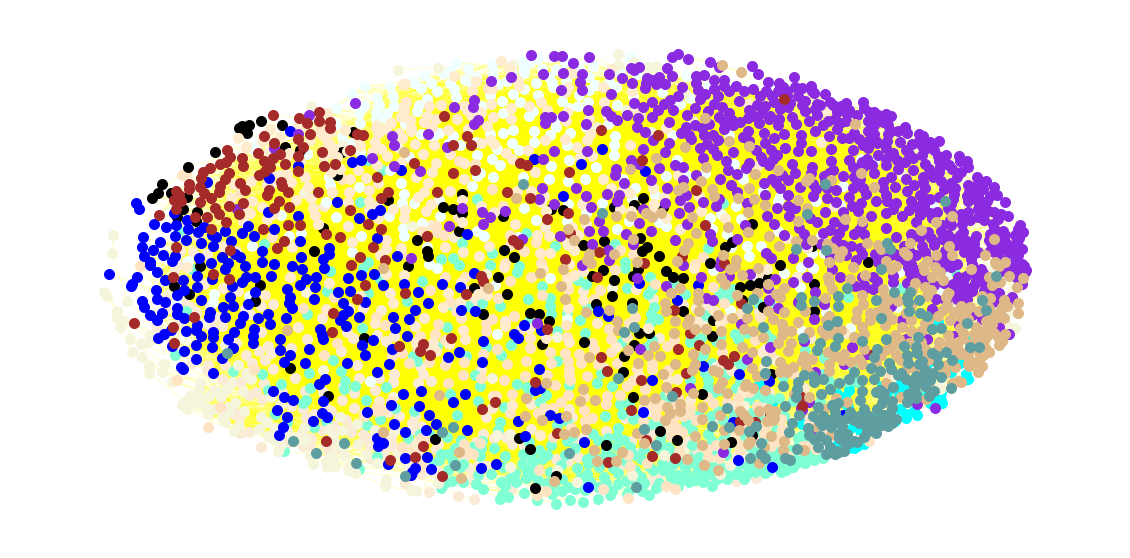

In [71]:
fa_community_plot(anime_GCC, anime_partition)

In [72]:
anime_freq = nltk.FreqDist(anime_partition_values)
anime_freq

FreqDist({9: 701, 11: 419, 2: 416, 7: 275, 8: 259, 3: 237, 5: 231, 0: 214, 12: 204, 10: 177, ...})

In [73]:
# Based on what we know of the sizes of each community, it is probably only interesting to look at the 12 biggest communities.
anime_corpus = text_processing(anime_partition, list(anime_freq))

5725


In [74]:
# A list of all the tf list from each community
community_list_freq= []

for i, community_text in zip(list(anime_freq), anime_corpus):
    
    # To have the term frequency in count
    term_freqdist = nltk.FreqDist(community_text)

    # To have the term frequency in count / N format, which is the tf-format of the example from the wikipage of TF-IDF
    total = term_freqdist.N()
    for word in term_freqdist:
        term_freqdist[word] /= float(total)
    
    # Add every term frequency distribution for a community in our list
    community_list_freq.append(term_freqdist)

    # Printing out the top 5 terms of each community (percentage)
    print("Community " + str(i) + " has " + str(anime_freq[i]) + " anime and has these top 5 terms according to TF:")
    print(term_freqdist.most_common(5))

Community 9 has 701 anime and has these top 5 terms according to TF:
[('school', 0.011123187567930069), ('girl', 0.008417547348703836), ('life', 0.0072381657146821455), ('new', 0.0058275327798718865), ('friend', 0.005619406609162177)]
Community 11 has 419 anime and has these top 5 terms according to TF:
[('girl', 0.008172515623926927), ('world', 0.006970675090996498), ('school', 0.006489938877824325), ('one', 0.006112217567474761), ('find', 0.0059405260627704145)]
Community 2 has 416 anime and has these top 5 terms according to TF:
[('earth', 0.0071057136397403185), ('world', 0.0064274409741287425), ('one', 0.0058137657052420785), ('girl', 0.005523077419979975), ('know', 0.005329285229805239)]
Community 7 has 275 anime and has these top 5 terms according to TF:
[('school', 0.009518143961927425), ('girl', 0.009220701963117191), ('life', 0.007485623636724172), ('world', 0.006395002974419988), ('one', 0.006246281975014872)]
Community 8 has 259 anime and has these top 5 terms according to 

In [75]:
# In this code section, we want to calculate the IDF of every word from the whole anime_corpus
idf_list = []
# Extract all words from the whole anime_corpus
anime_words = [item for document in anime_corpus for item in document]

# Check amount of occurence of a word
for word in set(anime_words):
    occurences = 0

    # Check if the word occurs on each community text. Max occurence is the total amount of text documents of the corpus
    for community_text in anime_corpus:
        if word in community_text:
            occurences += 1
    
    # Calculate the inverse document frequency
    idf = np.log(len(anime_corpus)/occurences)
    idf_list.append((word,idf))

# Convert the list of tuples to a dictionary, which we will use later
idf_dict = dict(idf_list)

In [76]:
idf_list

[('tadashi', 1.8718021769015913),
 ('morohas', 2.5649493574615367),
 ('required', 1.466337068793427),
 ('yesterday', 1.8718021769015913),
 ('boyssextuplets', 2.5649493574615367),
 ('yadomi', 2.5649493574615367),
 ('usamis', 2.5649493574615367),
 ('saruta', 2.5649493574615367),
 ('landstriking', 2.5649493574615367),
 ('pitch', 1.1786549963416462),
 ('22yearold', 2.5649493574615367),
 ('filmmaker', 2.5649493574615367),
 ('haiku', 2.5649493574615367),
 ('itsumo', 2.5649493574615367),
 ('voiceless', 2.5649493574615367),
 ('valuable', 0.6190392084062235),
 ('chibiusa', 2.5649493574615367),
 ('doremis', 2.5649493574615367),
 ('unpopular', 1.8718021769015913),
 ('s30', 2.5649493574615367),
 ('reconnects', 1.8718021769015913),
 ('galbeston', 2.5649493574615367),
 ('kakushigoto', 2.5649493574615367),
 ('rotarous', 2.5649493574615367),
 ('vibration', 2.5649493574615367),
 ('eggmans', 2.5649493574615367),
 ('haruhikos', 2.5649493574615367),
 ('animation', 0.4855078157817008),
 ('0015', 2.56494935

In [77]:
# A list of all the tf-idf list from each community
community_list_tf_idf = []

for term_freqdist in community_list_freq:
    community_tf_idf = nltk.FreqDist(term_freqdist) # Copies values and ensures that we don't overwrite tf distribution

    for word in community_tf_idf:

        # Get the idf of the word from the idf dictionary we made previously
        idf = idf_dict[word]

        # tf-idf is calculated by the tf of a word within the document and the idf of the word of the document set (our corpus)
        community_tf_idf[word] = (dict(term_freqdist)[word] * idf)

    community_list_tf_idf.append(community_tf_idf)

In [78]:
# Listing the 10 top words for each community accourding to TF-IDF
for i, tf_idf in zip(list(anime_freq),community_list_tf_idf):
    print("The top 10 term according to TF-IDF for community " + str(i) + ":")
    print(tf_idf.most_common(10))

The top 10 term according to TF-IDF for community 9:
[('chef', 0.0007120939445612461), ('idol', 0.0007098633060309519), ('bread', 0.0005931478753697793), ('restaurant', 0.0005900438524548457), ('gintoki', 0.0005627136946955736), ('bocchi', 0.0005338330878328014), ('kana', 0.0005194280258728371), ('yorozuya', 0.0005194280258728371), ('hina', 0.0004906179019529087), ('comedic', 0.0004906179019529087)]
The top 10 term according to TF-IDF for community 11:
[('prism', 0.0014783136484010921), ('precure', 0.0013497646354966493), ('ichigo', 0.0010070304709796215), ('tenchi', 0.0009688360322806436), ('jewel', 0.00091869790745032), ('sawako', 0.0007712940774266567), ('jewelpets', 0.0007046080234768318), ('momona', 0.0007046080234768318), ('yui', 0.0006562127910359429), ('ruby', 0.0006475681595174212)]
The top 10 term according to TF-IDF for community 2:
[('colony', 0.0022259565980843987), ('squadron', 0.0009945763523355824), ('pilot', 0.0009914608359774056), ('gundam', 0.0007994494662050506), ('

In [79]:
# Function to make wordclouds with titles
from wordcloud import WordCloud
def make_word_cloud(tf_idf, community_number):

    # To make this work check: https://stackoverflow.com/questions/47298070/importerror-no-module-named-wordcloud
    wordcloud = WordCloud(background_color='white')
    wordcloud.generate_from_frequencies(tf_idf) 
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("Community " + str(community_number))
    plt.show()

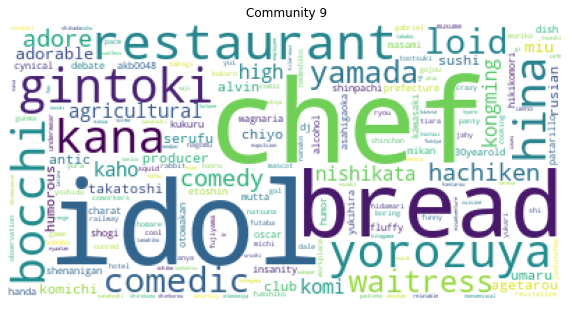

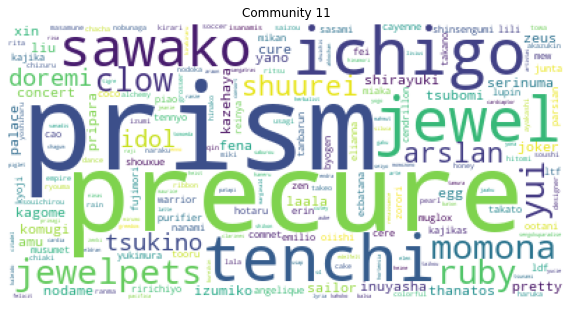

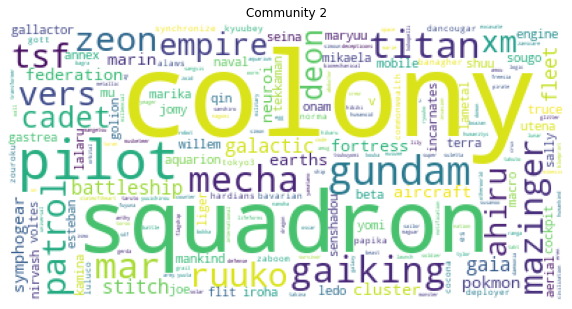

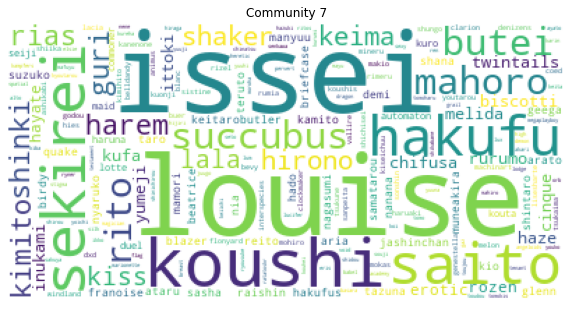

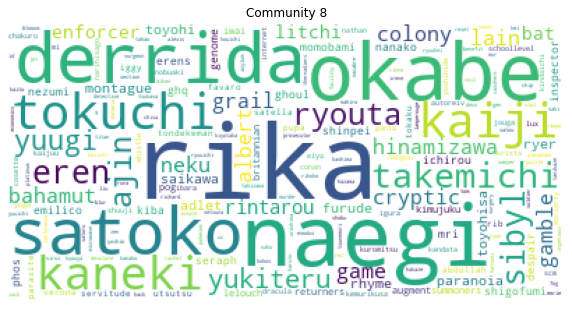

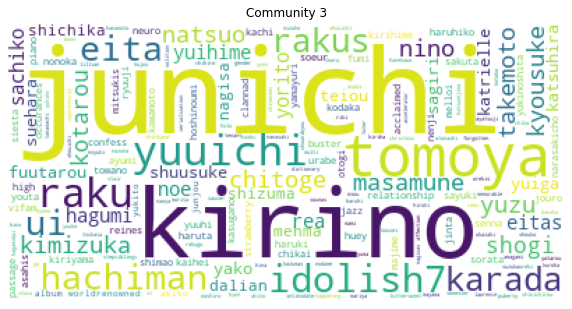

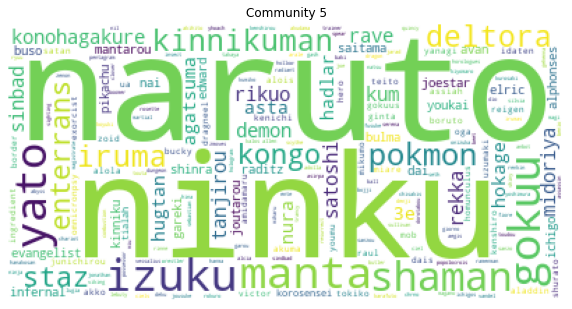

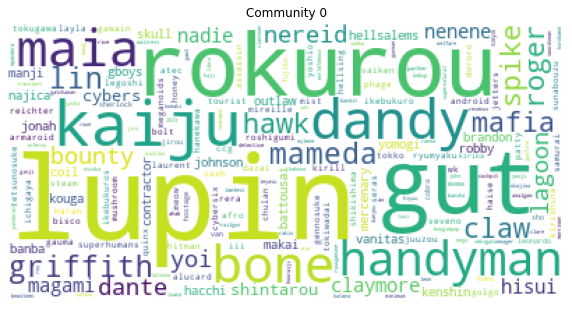

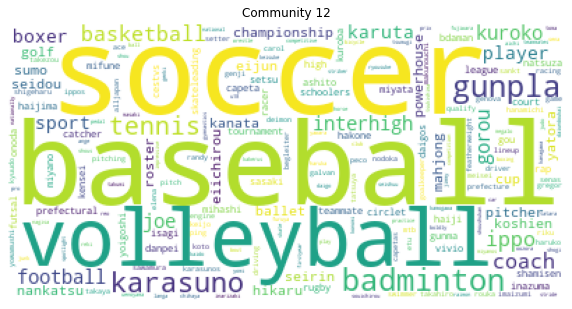

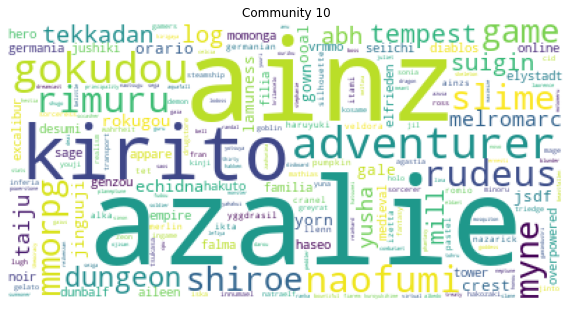

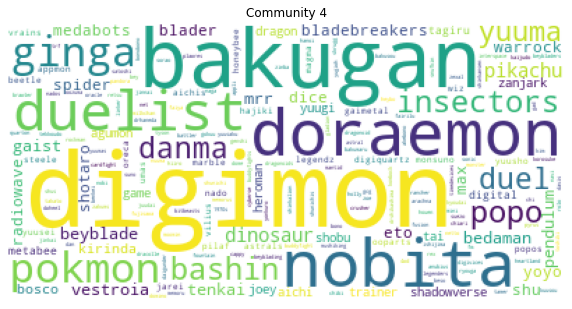

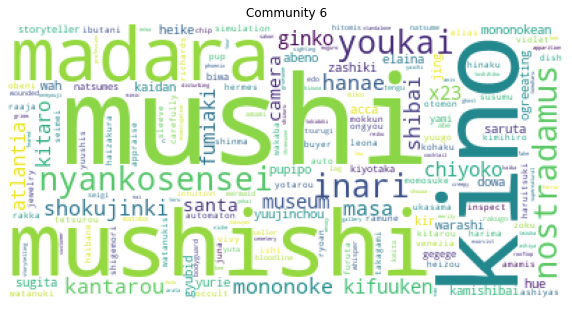

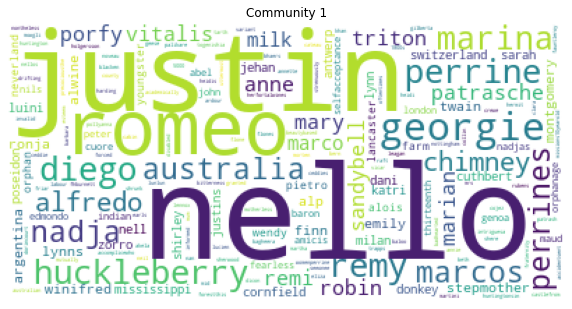

In [80]:
# Create word clouds for each DC community
for i, tf_idf in zip(list(anime_freq),community_list_tf_idf):
    make_word_cloud(dict(tf_idf),i)

**** 

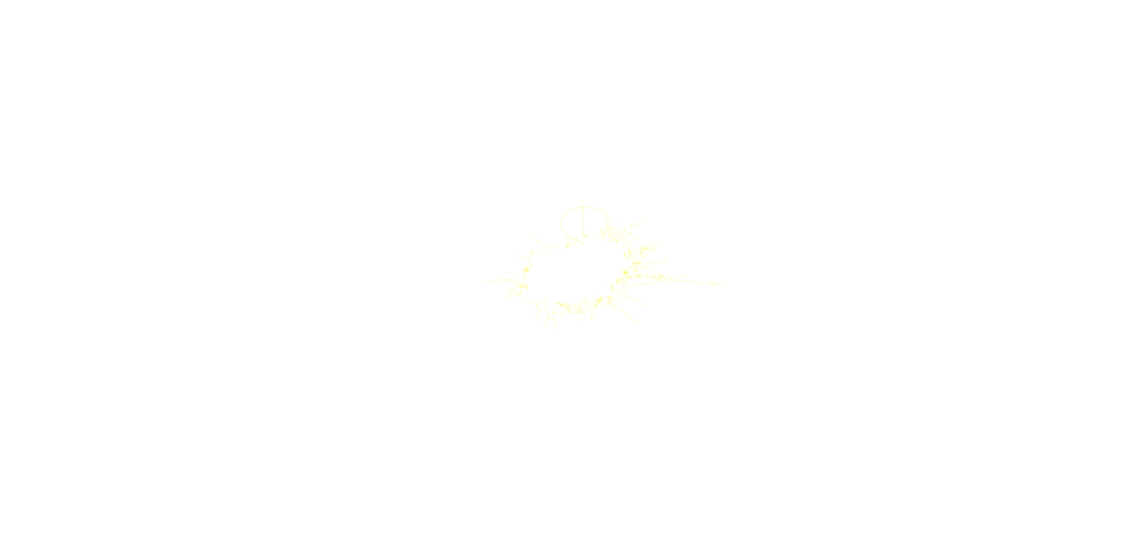

In [81]:
import fa2
d = dict(anime_graph.degree)
def fa_plot(graph,d,node_scale):
    color_map = []

    # for n in graph.nodes:
    #     if 'attr' in graph.nodes[n]:
    #         t = graph.nodes[n]['attr']['team']
    #         if t == 'dc':
    #             color_map.append("#ff0000")
    #         elif t =='marvel':
    #             color_map.append("#A0CBE2")
    #     else:
    #         color_map.append("#000000")
            
    forceatlas2 = fa2.ForceAtlas2(
                            # Behavior alternatives
                            outboundAttractionDistribution=False,
                            linLogMode=False,
                            adjustSizes=False,
                            edgeWeightInfluence=0.5,

                            # Performance
                            jitterTolerance=1.0,  # Tolerance
                            barnesHutOptimize=True,
                            barnesHutTheta=1.2,
                            multiThreaded=False,  # NOT IMPLEMENTED

                            # Tuning
                            scalingRatio=2.0,
                            strongGravityMode=False,
                            gravity=1.0,

                            # Log
                            verbose=False)

    positions = forceatlas2.forceatlas2_networkx_layout(graph, pos=None, iterations=500)
    nx.draw_networkx_edges(graph, positions, edge_color="yellow", alpha=0.2)
    nx.draw_networkx_nodes(graph, positions, node_size=[v * node_scale for v in d.values()], alpha=1, node_color='w')
    #Give the nodes their correct color
    nx.draw_networkx_nodes(graph, positions, node_color=color_map, node_size=[v * node_scale for v in d.values()], alpha=0.7)
    plt.axis('off')
    plt.show()
    
fa_plot(anime_graph,d,2)

# Sentiment

First we get the synopsis of each anime tv show, and store it in a seperate text file.

In [82]:
for anime in all_anime_tv:
    file_name = "{}.txt".format(anime['mal_id'])
    write_file = open("data/synopsis/"+file_name, "w")
    write_file.write(json.dumps(anime['synopsis']))
    write_file.close()

Tokenize the synopsis, and remove stop words.

In [83]:
from bs4 import BeautifulSoup
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.corpus import PlaintextCorpusReader
#The root is the directory
corpus_root_dc = r"data/synopsis" 
file_pattern = r".*\.txt"
ptb_dc = PlaintextCorpusReader(corpus_root_dc, file_pattern)
xx = 0
token_dict = {}
for fileid in ptb_dc.fileids():
    raw = ptb_dc.raw(fileids=fileid)
    #raw = BeautifulSoup(html, 'html.parser').get_text()
    try: 
        start = re.search('\"',raw).span()[1]
    except AttributeError:
        print("error")
    tokens = word_tokenize(raw[start:])
    token_dict[fileid.split('.txt')[0]] = [w.lower() for w in tokens if w.isalpha()]

stop_words = stopwords.words('english')

for k,v in token_dict.items(): #remove stop words from token_dict for later sentiment use
    token_dict[k] = [w for w in v if w not in stop_words]

Store the average happiness score of words:

In [84]:
class Word:
    def __init__(self,word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank):
        self.word = word
        self.happiness_average = float(happiness_average)

labMIT = {}
with open("labMIT.txt") as f:
    for line in f:
       (word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank) = line.split()
       labMIT[word] = Word(word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank)


We create a function that can calculate the sentiment of a given tokenlist

In [85]:
def get_sentiment(tokenlist):
    sentiment = 0
    num_of_tokens = len(tokenlist)
    if num_of_tokens == 0:
        print('input tokenlist was empty')
        num_of_tokens = 1
    
    for w in tokenlist:
        try: 
            sentiment = sentiment + (labMIT[str(w)].happiness_average)
        except KeyError:
            if num_of_tokens > 1:
                num_of_tokens = num_of_tokens-1
                
    sentiment = sentiment/num_of_tokens
    return sentiment

We can now calculate the sentiment of all the synopsis

In [86]:
fails = 0
sentiments = []
for mal_id in anime_graph.nodes:
    try:
        s = get_sentiment(token_dict[str(mal_id)])
        anime_graph.nodes[mal_id]['Sentiment'] = s
        if s != 0: #We dont consider pages with sentiment 0, as these contain no words in our sentiment library.
            sentiments.append(s)
    except KeyError:
        fails = fails + 1

#print(fails,"nodes could not have their sentiment calculated")

We define a couple of functions for plotting pretty histograms along with their mean, as well as 10th and 90th percentile.

The functions: outlier_aware_sentiment_hist, mad, calculate_bounds is a modified version of the code posted by user Benjamin Doughty in the stackoverflow thread [Making pyplot.hist() first and last bins include outliers](https://stackoverflow.com/questions/15837810/making-pyplot-hist-first-and-last-bins-include-outliers)

In [87]:
def outlier_aware_sentiment_hist(data,mean,tenth,ninetieth,t,sent=False,lower=None, upper=None):
    if not lower or lower < min(data):
        lower = min(data)
        lower_outliers = False
    else:
        lower_outliers = True

    if not upper or upper > max(data):
        upper = max(data)
        upper_outliers = False
    else:
        upper_outliers = True

    n, bins, patches = plt.hist(data, range=(lower, upper), bins='auto',edgecolor='black')

    if lower_outliers:
        n_lower_outliers = sum(data < lower)
        patches[0].set_height(patches[0].get_height() + n_lower_outliers)
        patches[0].set_facecolor('c')
        patches[0].set_label('Lower outliers: ({:.2f}, {:.2f})'.format(min(data), lower))

    if upper_outliers:
        n_upper_outliers = sum(data > upper)
        patches[-1].set_height(patches[-1].get_height() + n_upper_outliers)
        patches[-1].set_facecolor('m')
        patches[-1].set_label('Upper outliers: ({:.2f}, {:.2f})'.format(upper, max(data)))
    if sent:
        plt.plot([mean,mean],[0,max(n)*1.02],linewidth=5)
        plt.plot([tenth,tenth],[0,max(n)*1.02],linewidth=5)
        plt.plot([ninetieth,ninetieth],[0,max(n)*1.02],linewidth=5)
        plt.legend(['Lower outliers: ({:.2f}, {:.2f})'.format(min(data), lower),('Upper outliers: ({:.2f}, {:.2f})'.format(upper, max(data))),('Distribution Mean: {:.2f}'.format(mean)),('10th percentile: {:.2f}'.format(tenth)),'90th percentile: {:.2f}'.format(ninetieth)])
        plt.xlabel('Sentiment value')
        plt.ylabel('Count')
    else:
        plt.legend()
    plt.title(t)
        
def mad(data):
    median = np.median(data)
    diff = np.abs(data - median)
    mad = np.median(diff)
    return mad

def calculate_bounds(data, z_thresh=3.5):
    MAD = mad(data)
    median = np.median(data)
    const = z_thresh * MAD / 0.6745
    return (median - const, median + const)

def sentiment_stats_and_hist(sents,t):
    sent_mean = mean(sents)
    tenth = np.percentile(sents,10)
    ninetieth = np.percentile(sents,90)
    print("Sentiment mean:",sent_mean)
    print("tenth percentile:",tenth)
    print("ninetieth percentile:",ninetieth)
    outlier_aware_sentiment_hist(sents,sent_mean,tenth,ninetieth,t,True,*calculate_bounds(sents))


Sentiment mean: 5.717111280707003
tenth percentile: 5.356
ninetieth percentile: 6.069775000000001


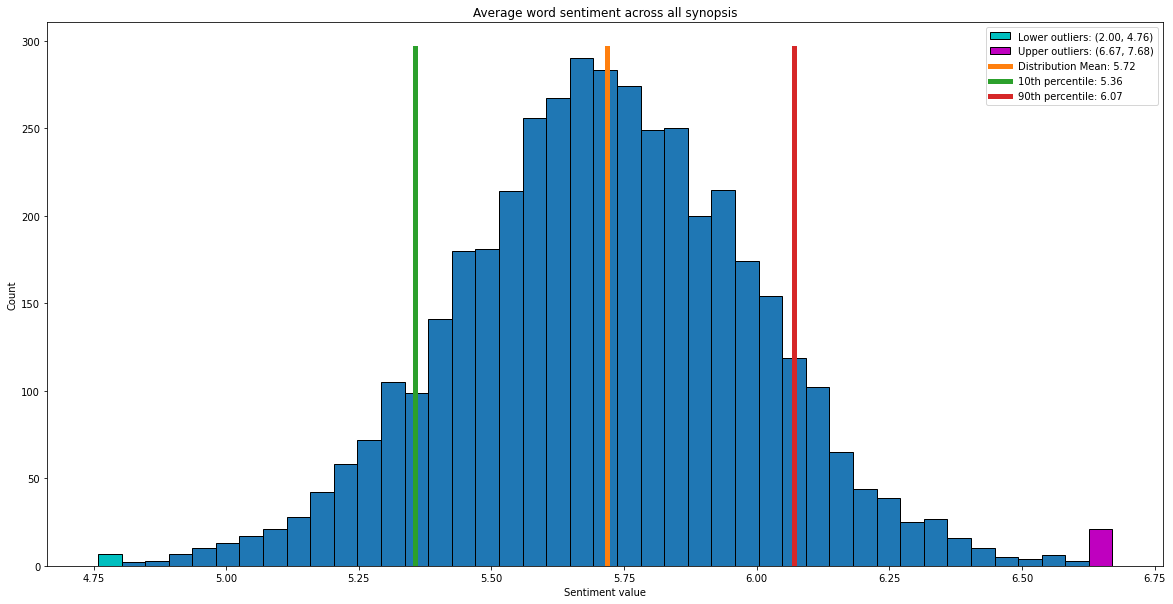

In [88]:
sentiment_stats_and_hist(sentiments,'Average word sentiment across all synopsis')

# Next steps

Split datasettet op i nogle kategorier og sammenlign?<br>F.eks. høj rating vs lav rating? men hvor er cut offet?<br>
Evt. gradierer farven på noderne i plottet alt efter rating? hvis det er muligt, kunne være blæret.<br>
Evt. et møde med sune for at høre hvad der giver mening.